<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Gaussian_Mapping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Generating a Gaussian Random field**

Let $\varphi$ be a real valued stationary Gaussian field on $\mathbb{R}^d$ such that for all $x \in \mathbb{R}^d$, $\varphi(x)$ defines a random variable and $(\varphi(x), x \in \mathbb{R}^d)$ defines a family of indentically distributed random variables on the probability space $(\Omega, \mathcal{F}, P)$.


The random field is completely characterised by its mean and covariance
\begin{align*}
\mu  &= \mathbb{E}(\varphi(0)) = \mathbb{E}(\varphi(x)), \\
C(x) &= \mathbb{E}(\varphi(0)\varphi(x)) - \mu^2 = \mathbb{E}(\varphi(x)\varphi(x+y)) - \mu^2, \quad \forall \quad x,y \in \mathbb{R}^d.
\end{align*}

To generate $\varphi$ we make use of $W$ a Gaussian White noise random field on $\mathbb{R}^d$ such that $\{ W(x), x \in \mathbb{R}^d \}$ is a family with $\mathbb{E}(W(x)W(y)) = \delta(x-y)$. Letting the Fourier transform of this white noise process be defined as
\begin{equation}
FW(k) \equiv F \circ W(x) = \int_{\mathbb{R}^d} e^{2 \pi i (k,x)} W(x) dx,
\end{equation}
we can then write
\begin{equation}
\varphi(x) = (F^{-1} P^{1/2} F W)(x),
\end{equation}
where
\begin{equation}
P(k) = \int C(x) e^{ikx} dx
\end{equation}
is the power spectrum of the correlation function such that the covariance is given by
\begin{equation}
\mathbb{E}(\varphi(x)\varphi(y)) = C(x,y) = \int e^{2 \pi i (k,x-y)} P (k) dk.
\end{equation}

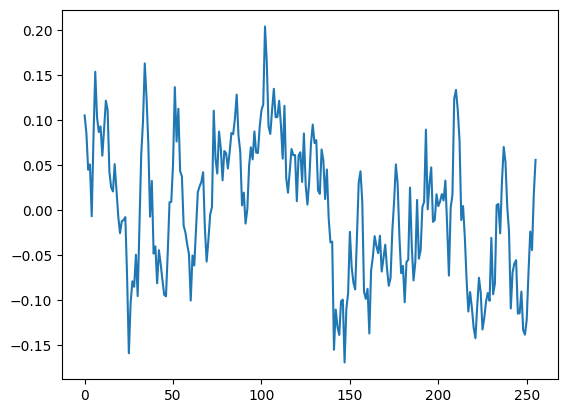

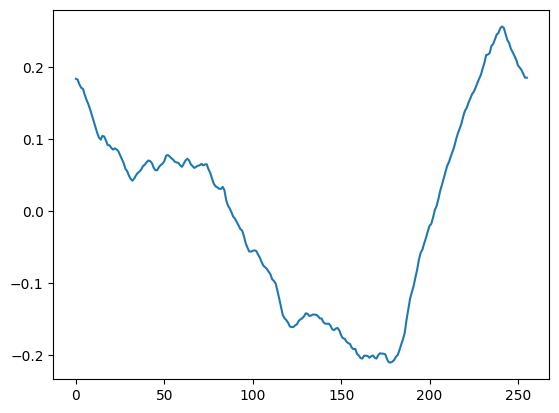

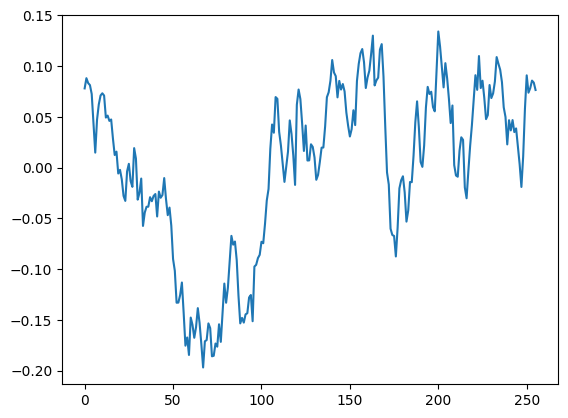

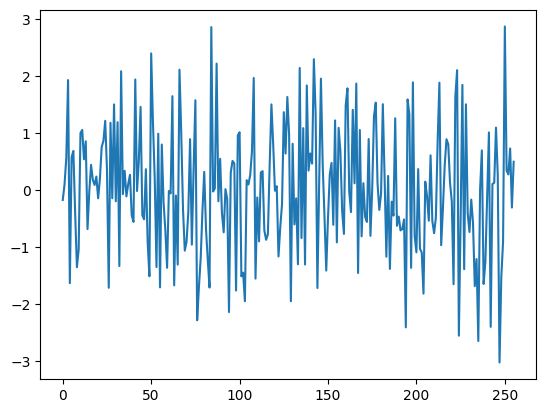

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def fftIndgen(n):
  a = np.arange(0, n//2 + 1)
  b = np.arange(1, n//2)[::-1]
  b = [-i for i in b]
  return np.hstack((a,b))

def gaussian_random_field_2D(Pk = lambda k : k**-3.0, size = 100):

  def Pk2(kx, ky):
    if kx == 0 and ky == 0:
      return 0.0
    return np.sqrt(Pk(np.sqrt(kx**2 + ky**2)))

  W  = np.random.normal(size = (size, size))
  FW = np.fft.fft2(W)

  P_k = np.zeros((size,size))
  for i, kx in enumerate(fftIndgen(size)):
    for j, ky in enumerate(fftIndgen(size)):
      P_k[i, j] = Pk2(kx, ky)

  return np.fft.ifft2(P_k * FW)


def gaussian_random_field_1D(Pk = lambda k : k**-3.0, size = 100):

  def Pk2(kx):
    if kx == 0:
      return 0.0
    return np.sqrt(Pk(np.sqrt(kx**2)))

  W  = np.random.normal(size = (size,))
  FW = np.fft.fft(W)

  P_k = np.zeros(size)
  for i, kx in enumerate(fftIndgen(size)):
    P_k[i] = Pk2(kx)

  return np.fft.ifft(P_k * FW)



for alpha in [-5./3., -3.0, -2.0,0.]:

  #out = gaussian_random_field_1D(Pk = lambda k: k**alpha, size=256)
  #plt.figure()
  #plt.imshow(out.real, interpolation='none')

  out = gaussian_random_field_1D(Pk = lambda k: k**alpha, size=256)
  plt.figure()
  plt.plot(out.real)
  plt.show()

Some nice texts on this topic are from which I created this are:

https://structures.uni-heidelberg.de/blog/posts/gaussian-random-fields/index.php

https://arxiv.org/pdf/1105.2737

https://andrewwalker.github.io/statefultransitions/post/gaussian-fields/
